In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
% matplotlib inline

C:\Users\Hong Jie\Anaconda3\envs\python35\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
def load_matching_data(path_to_data, key, match_values, chunksize=30000, set_index=True):
    df = pd.read_json(path_to_data, lines=True, orient='columns', chunksize=chunksize)
    final = []
    for chunk in tqdm(df):
        final.append(chunk[chunk[key].isin(match_values)])
    if set_index:
        return pd.concat(final).set_index(key)
    else:
        return pd.concat(final)

# EDA

## reviews

In [26]:
# for reading in raw json
num_reviews = 100000
df = pd.read_json(root + '/review.json', lines=True, orient='columns', chunksize=num_reviews)
for review in df:
    #review = chunk
    break
review.set_index('review_id', inplace=True)
review.head()

,business_id,cool,date,funny,stars,text,useful,user_id
review_id,,,,,,,,
Q1sbwvVQXV2734tPgoKj4Q,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
GJXCdrto3ASJOqKeVWPi6Q,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2TzJjDVDEuAW6MR5Vuc1ug,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
yi0R0Ugj_xUx_Nek0-_Qig,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
11a8sVPMUFtaC7_ABRkmtw,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


## business id

In [3]:
# for reading in raw json
#num_reviews = 192609
business = pd.read_json('yelp_dataset/business.json', lines=True, orient='columns')#, chunksize=num_reviews)
business.set_index('business_id', inplace=True)
business.head()

,address,attributes,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
business_id,,,,,,,,,,,,,
1SWheh84yJXfytovILXOAQ,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
QXAEGFB4oINsVuTFxEYKFQ,30 Eglinton Avenue W,"{'GoodForKids': 'True', 'RestaurantsTableServi...","Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Saturday': '9:0-1:0', 'Wednesday': '9:0-0:0'...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
gnKjwL_1w79qoiV3IC_xQQ,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'RestaurantsTableServi...","Sushi Bars, Restaurants, Japanese",Charlotte,"{'Saturday': '17:30-22:0', 'Wednesday': '17:30...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
xvX2CttrVhyG2z1dFg_0xw,"15655 W Roosevelt St, Ste 237",None,"Insurance, Financial Services",Goodyear,"{'Friday': '8:0-17:0', 'Wednesday': '8:0-17:0'...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
HhyxOkGAM07SRYtlQ4wMFQ,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsCreditCards': 'True', 'Busine...","Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Saturday': '7:0-23:0', 'Wednesday': '7:0-23:...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [4]:
cheesecake = business[business.name == 'The Cheesecake Factory']
shakeshack = business[business.name == 'Shake Shack']
innout = business[business.name == 'In-N-Out Burger']

# In-N-Out

Get all business Ids, get all reviews on all business locations and join.

In [5]:
reviews_innout = load_matching_data('yelp_dataset/review.json',
                             key='business_id',
                             match_values=innout.index.tolist(),
                             chunksize=20000) # (6919, 8)
customers_innout = reviews_innout.user_id.drop_duplicates().tolist()
users_innout = load_matching_data('yelp_dataset/user.json',
                           key='user_id', match_values=customers_innout,
                           chunksize=20000)

In [6]:
df_innout = reviews_innout.merge(users_innout, how='left',
                                 left_on='user_id', right_index=True)
df_innout['year'] = df_innout.date.dt.year.astype(str)
df_innout['is_elite'] = [x in y for x, y in 
                         zip(df_innout.year.tolist(), df_innout.elite.tolist())]

In [7]:
df_innout['influence'] = df_innout.is_elite.astype(int) * 100 \
                        + df_innout.useful_x + df_innout.funny_x \
                        + df_innout.cool_x + df_innout.fans + 1

In [11]:
# take top 5% by total review influence as influencers
influencers = df_innout.groupby('user_id')['influence'].sum()\
                        .sort_values(ascending=False)[:315]\
                        .index.tolist()

In [12]:
df_innout['influencer_rating'] = df_innout.user_id.isin(influencers) \
                            * df_innout.stars \
                            / df_innout.average_stars # adjust for avg stars

In [13]:
# load checkins
checkins = load_matching_data('./yelp_dataset/checkin.json', 
                              key='business_id',
                              match_values=innout.index.tolist(),
                              chunksize=20000,
                              set_index=False)

In [15]:
checkins.date = checkins.date.str.split(', ')
pd.to_datetime(checkins.date.sum()).dayofweek.value_counts() # sat and sun top

5    9579
6    9381
4    8065
0    7809
3    7126
2    6733
1    6501
dtype: int64

In [21]:
checkins.date.apply(len).sort_values(ascending=False) # checkins dominated by a 4 stores

130467    7323
83813     4561
54885     3812
137529    3580
21759     2822
90858     2759
146353    2424
124046    2189
508       2054
128709    1859
35723     1694
158524    1589
106191    1551
146785    1495
41039     1357
148401    1235
160836    1195
138069    1172
55407     1125
86258     1119
65081     1051
132238    1015
40097      942
146491     896
128303     806
5104       783
33664      751
67375      668
145919     663
6984       519
97515      129
70985       44
39166       12
Name: date, dtype: int64

In [17]:
checkin_times = pd.DataFrame(pd.to_datetime(checkins.date.sum()), columns=['datetime'])
checkin_times['dummy'] = 1
checkin_times['date'] = checkin_times.datetime.dt.date
checkin_times = checkin_times.groupby('date')['dummy'].sum()\
                            .asfreq('D').fillna(0.)

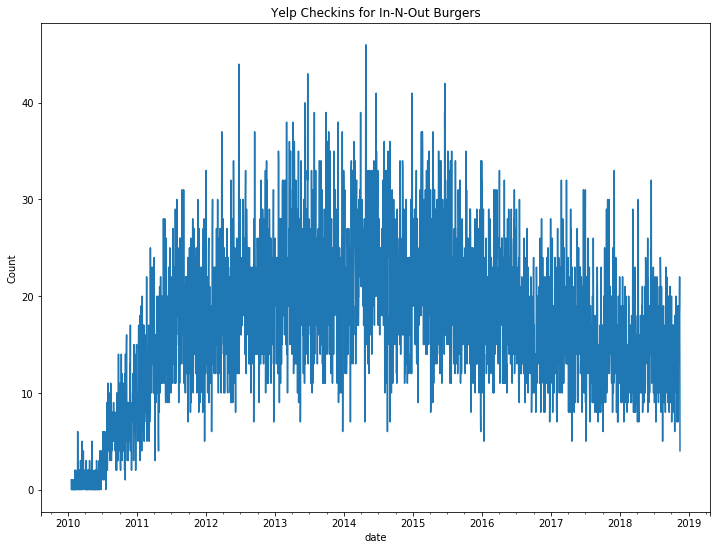

In [18]:
checkin_times.plot(figsize=(12,9))
plt.title('Yelp Checkins for In-N-Out Burgers')
plt.ylabel('Count');

In [ ]:
df_innout.date = df_innout.date.dt.date

In [19]:
nlp = SentimentIntensityAnalyzer()

In [ ]:
df_innout['sentiment'] = df_innout.text.apply(lambda x: nlp.polarity_scores(x)['compound'])

In [77]:
endog = df_innout[['date', 'stars', 'sentiment', 'influencer_rating']]\
            .groupby('date').agg({'stars':np.mean,
                                  'sentiment':np.mean,
                                  'influencer_rating':np.sum})
endog = endog.asfreq('D').fillna(0.0)
endog['checkins'] = checkin_times

In [52]:
# def test_vader(index, df):
#     print(df.text[index])
#     print('Combined: %.3f' % nlp.polarity_scores(df.text[index])['compound'])
#     print('Averaged: %.3f' % np.mean([nlp.polarity_scores(x)['compound']
#                                   for x in df.text[index].split('.')]))
#     print('')

# [test_vader(i, df_innout) for i in range(10)]

## Explore time series

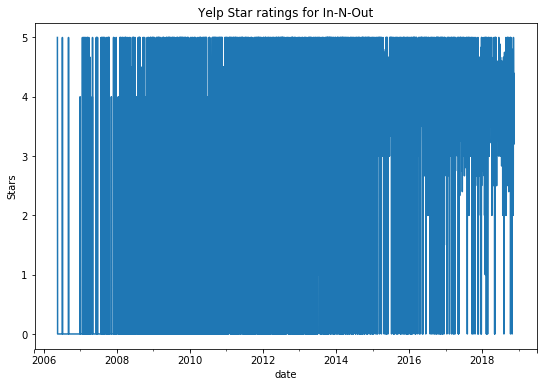

In [23]:
endog['stars'].plot(figsize=(9,6));
plt.title('Yelp Star ratings for In-N-Out')
plt.ylabel('Stars');

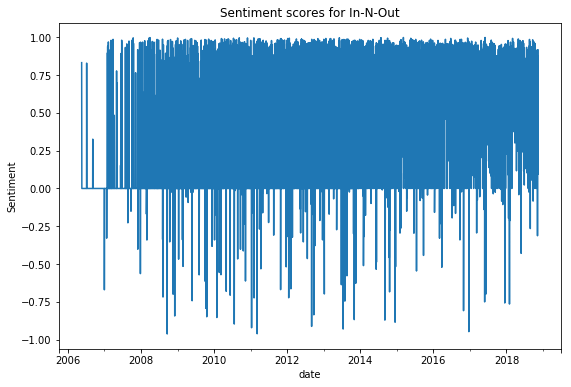

In [60]:
endog['sentiment'].plot(figsize=(9,6));
plt.title('Sentiment scores for In-N-Out')
plt.ylabel('Sentiment');

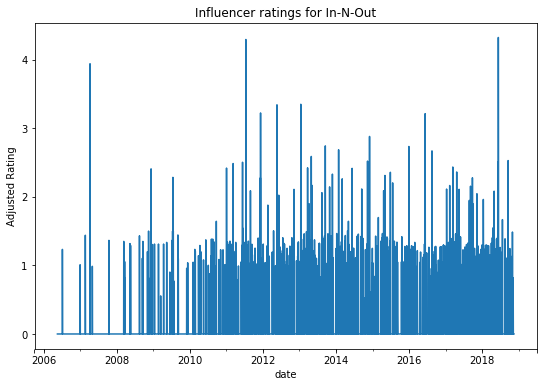

In [26]:
endog['influencer_rating'].plot(figsize=(9,6));
plt.title('Influencer ratings for In-N-Out')
plt.ylabel('Adjusted Rating');

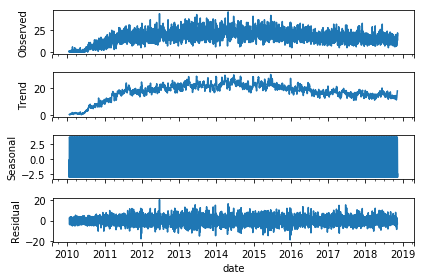

In [34]:
decomposed = sm.seasonal_decompose(endog['checkins'])
decomposed.plot();

In [41]:
sm.stattools.adfuller(endog['checkins'].diff()[1:], maxlag=365) # diff order 1

(-10.722271359782685,
 3.1288599529308036e-19,
 68,
 3153,
 {'1%': -3.4324256840496985,
  '10%': -2.5672581988257397,
  '5%': -2.8624571096973295},
 17461.32805003912)

In [61]:
sm.stattools.adfuller(endog['sentiment'].diff()[1:], maxlag=365) # diff order 1

(-15.61704644665974,
 1.7507483591504011e-28,
 61,
 4500,
 {'1%': -3.431804007587742,
  '10%': -2.567112005382716,
  '5%': -2.8621824984147053},
 4067.3183141517757)

In [43]:
sm.stattools.adfuller(endog['stars'].diff()[1:], maxlag=180) # diff order 1

(-13.804466580524872,
 8.452414643391178e-26,
 61,
 3160,
 {'1%': -3.432421082272174,
  '10%': -2.567257116748117,
  '5%': -2.8624550771782253},
 11905.932934711916)

In [63]:
sm.stattools.adfuller(endog['influencer_rating'].diff()[1:], maxlag=180) # diff order 1

(-15.208049840966718,
 5.705878716081252e-28,
 61,
 4500,
 {'1%': -3.431804007587742,
  '10%': -2.567112005382716,
  '5%': -2.8621824984147053},
 5414.405371531291)

In [67]:
endog = endog.diff()[1:].dropna()
innout_model = sm.VAR(endog)
innout_model.select_order(maxlags=30, trend='c').summary() # aic = 13, bic = 6, use 13 and see

,AIC,BIC,FPE,HQIC
0,3.052,3.059,21.15,3.055
1,2.005,2.043,7.422,2.018
2,1.622,1.690,5.062,1.646
3,1.362,1.461,3.903,1.397
4,1.177,1.306,3.244,1.223
5,1.002,1.162,2.724,1.059
6,0.8747,1.065,2.398,0.9428
7,0.7967,1.017*,2.218,0.8757
8,0.7698,1.021,2.159,0.8598
9,0.7412,1.023,2.099,0.8421


In [ ]:
innout_res = innout_model.fit(maxlags=28, ic='aic', trend='c')

In [69]:
print(innout_res.is_stable())
innout_res.test_whiteness(10).summary()

True


Test statistic,Critical value,p-value,df
9.843,nan,NAN,-288


## Granger causality and IRF

In [72]:
innout_res.test_causality(0, [1,2,3], kind='wald').summary()

Test statistic,Critical value,p-value,df
101.6,106.4,0.093,84


In [73]:
innout_res.test_inst_causality([1,2,3]).summary() # orth effects present

Test statistic,Critical value,p-value,df
1067.,7.815,0.000,3


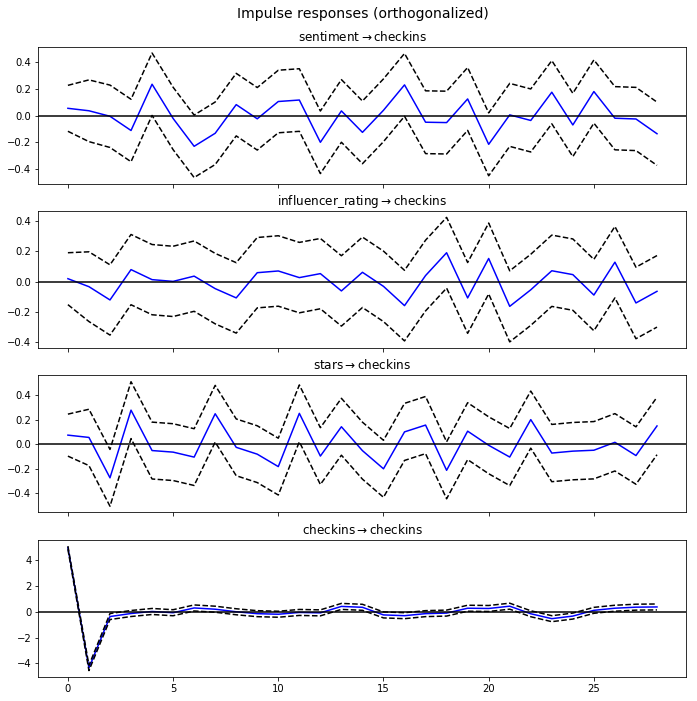

In [75]:
irf = innout_res.irf(periods=28)
irf.plot(orth=True, response='checkins', seed=12345);

## Deseasonalise

In [81]:
des_endog = endog.dropna().apply(lambda x: sm.seasonal_decompose(x).trend)\
                 .dropna().diff()[1:]

In [82]:
des_endog.apply(lambda x: sm.adfuller(x, maxlag=365)[1])

sentiment            2.658331e-10
influencer_rating    9.253923e-10
stars                2.752207e-08
checkins             2.070943e-05
dtype: float64

In [84]:
des_innout_model = sm.VAR(des_endog)
des_innout_model.select_order(maxlags=30, trend='c').summary() # 28

,AIC,BIC,FPE,HQIC
0,-12.56,-12.55,3.520e-06,-12.55
1,-12.55,-12.52,3.527e-06,-12.54
2,-12.56,-12.49,3.507e-06,-12.54
3,-12.56,-12.46,3.522e-06,-12.52
4,-12.55,-12.42,3.537e-06,-12.51
5,-12.55,-12.39,3.534e-06,-12.50
6,-12.55,-12.36,3.551e-06,-12.48
7,-13.72,-13.50,1.095e-06,-13.65
8,-13.72,-13.47,1.096e-06,-13.63
9,-13.72,-13.44,1.100e-06,-13.62


In [85]:
des_innout_res = des_innout_model.fit(maxlags=28, ic='aic', trend='c')
print(des_innout_res.is_stable())
des_innout_res.test_whiteness(10).summary()

True


Test statistic,Critical value,p-value,df
23.60,nan,NAN,-288


In [87]:
des_innout_model.endog_names

['sentiment', 'influencer_rating', 'stars', 'checkins']

In [89]:
des_innout_res.test_causality(3, [0,1,2], kind='wald').summary()

Test statistic,Critical value,p-value,df
97.57,106.4,0.148,84


In [90]:
des_innout_res.test_inst_causality([0,1,2]).summary()

Test statistic,Critical value,p-value,df
3.259,7.815,0.353,3


In [ ]:
des_irf = des_innout_res.irf(periods=28)

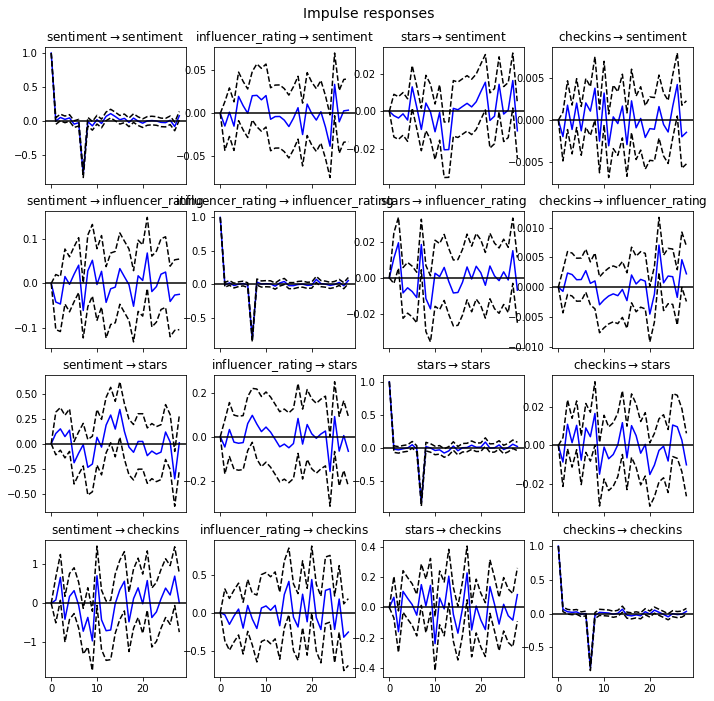

In [96]:
des_irf.plot(orth=False, seed=12345);

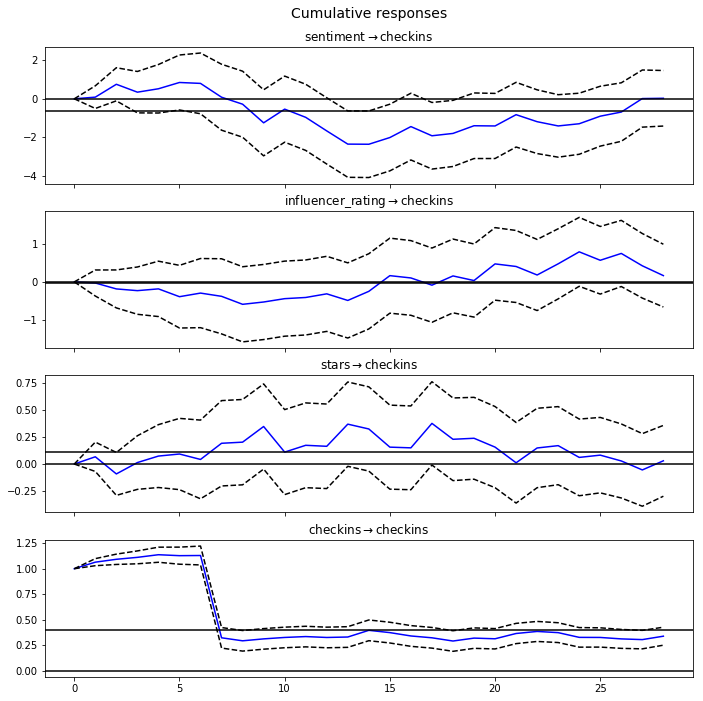

In [95]:
des_irf.plot_cum_effects(response='checkins', seed=12345);

# Shake Shack

In [6]:
reviews = load_matching_data('yelp_dataset/review.json',
                             key='business_id',
                             match_values=shakeshack.index.tolist(),
                             chunksize=20000) # (6919, 8)
customers = reviews.user_id.drop_duplicates().tolist()
users = load_matching_data('yelp_dataset/user.json',
                           key='user_id', match_values=customers,
                           chunksize=20000)

In [8]:
df = reviews.merge(users, how='left', left_on='user_id', right_index=True)
df['year'] = df.date.dt.year.astype(str)
df['is_elite'] = [x in y for x, y in zip(df.year.tolist(), df.elite.tolist())]
df['influence'] = df.is_elite.astype(int) * 100 + df.useful_x + df.funny_x + df.cool_x + df.fans + 1

influencers = df.groupby('user_id')['influence'].sum()\
                .sort_values(ascending=False)[:258]\
                .index.tolist()

df['influencer_rating'] = df.user_id.isin(influencers) \
                            * df.stars \
                            / df.average_stars # adjust for avg stars

In [19]:
# load checkins
checkins = load_matching_data('./yelp_dataset/checkin.json', 
                              key='business_id',
                              match_values=shakeshack.index.tolist(),
                              chunksize=20000,
                              set_index=False)

checkins.date = checkins.date.str.split(', ')

In [25]:
pd.to_datetime(checkins.date.sum()).dayofweek.value_counts() # sat and sun top

6    4856
5    4736
4    2914
0    2910
1    1990
3    1987
2    1777
dtype: int64

In [26]:
checkins.date.apply(len) # checkins dominated by 1 store

30771       379
33899       235
53590       331
56924       325
67071       862
69351     14975
82754        88
108977      507
119641     1910
145394     1558
Name: date, dtype: int64

In [27]:
checkin_times = pd.DataFrame(pd.to_datetime(checkins.date.sum()), columns=['datetime'])
checkin_times['dummy'] = 1
checkin_times['date'] = checkin_times.datetime.dt.date
checkin_times = checkin_times.groupby('date')['dummy'].sum()\
                            .asfreq('D').fillna(0.)

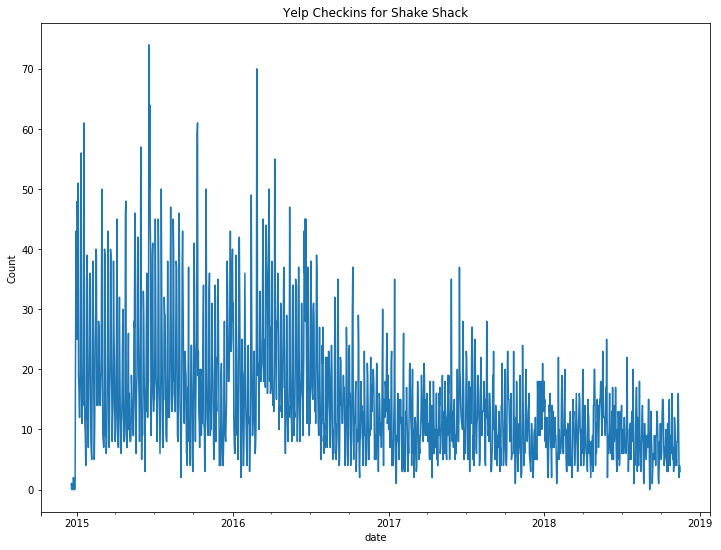

In [34]:
checkin_times.plot(figsize=(12,9))
plt.title('Yelp Checkins for Shake Shack')
plt.ylabel('Count');

In [14]:
# res = {}
# for biz in checkins:
#     test = pd.DataFrame(pd.to_datetime(checkins[biz]), columns=['datetime'])
#     test['dummy'] = 1
#     test['date'] = test.datetime.dt.date
#     res[biz] = test.groupby('date')['dummy'].sum()\
#                     .asfreq('D').fillna(0.)

In [15]:
nlp = SentimentIntensityAnalyzer()

In [248]:
df.text[2]

"Line was short on a Tuesday night, burgers were great but they charge for adding toppings like lettuce tomatoes and onion on burgers that don't include it. I wish they had more topping options and told you how much to add them on the signage. Fries were good but cheese fries were nasty, regular fries tasted like they have no salt on them but have a good texture. chocolate shake is kinda weird and has a powdered chocolate (think Ovaltine) texture. so I'd give it 3/5!"

In [246]:
nlp.polarity_scores(df.text[2])['compound']

0.5851

In [245]:
np.mean([nlp.polarity_scores(x)['compound'] for x in df.text[2].split('.')])

0.18348000000000003

In [16]:
df['sentiment'] = df.text.apply(lambda s: np.mean([nlp.polarity_scores(x)['compound']
                                                   for x in s.split('.')]))
df.date = df.date.dt.date

endog = df[['date', 'stars', 'sentiment', 'influencer_rating']]\
            .groupby('date').agg({'stars':np.mean,
                                  'sentiment':np.mean,
                                  'influencer_rating':np.sum})
endog = endog.asfreq('D').fillna(0.0)
endog['checkins'] = checkin_times

In [17]:
# for key in res:
#     endog = df.loc[key, ['date', 'stars', 'sentiment', 'influencer_rating']]\
#                 .groupby('date').agg({'stars':np.mean,
#                                       'sentiment':np.mean,
#                                       'influencer_rating':np.sum})
#     endog = endog.asfreq('D').fillna(0.0)
#     endog['checkins'] = res[key]
#     final[key] = endog

## Explore time series

Text(0,0.5,'Stars')

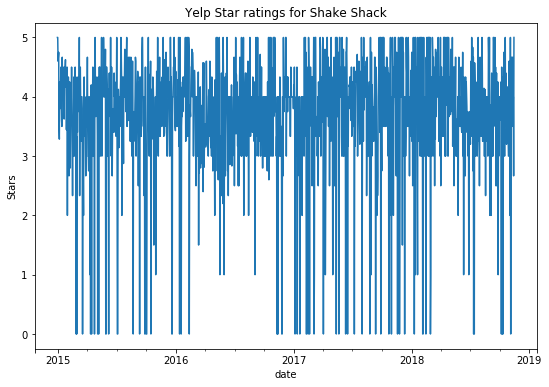

In [46]:
endog['stars'].plot(figsize=(9,6));
plt.title('Yelp Star ratings for Shake Shack')
plt.ylabel('Stars')

In [114]:
decomposed = sm.seasonal_decompose(endog['checkins'])

In [117]:
decomposed.trend

date
2014-12-29          NaN
2014-12-30          NaN
2014-12-31          NaN
2015-01-01    36.285714
2015-01-02    36.142857
2015-01-03    32.428571
2015-01-04    30.142857
2015-01-05    28.285714
2015-01-06    24.285714
2015-01-07    25.571429
2015-01-08    26.285714
2015-01-09    26.285714
2015-01-10    25.428571
2015-01-11    26.285714
2015-01-12    26.571429
2015-01-13    26.857143
2015-01-14    26.428571
2015-01-15    27.142857
2015-01-16    26.571429
2015-01-17    26.571429
2015-01-18    25.285714
2015-01-19    23.857143
2015-01-20    22.571429
2015-01-21    21.142857
2015-01-22    18.000000
2015-01-23    17.571429
2015-01-24    17.571429
2015-01-25    17.285714
2015-01-26    19.142857
2015-01-27    20.857143
                ...    
2018-10-16     6.000000
2018-10-17     6.285714
2018-10-18     7.714286
2018-10-19     7.714286
2018-10-20     7.857143
2018-10-21     7.571429
2018-10-22     8.000000
2018-10-23     8.285714
2018-10-24     8.857143
2018-10-25     7.714286
2018-10-26 

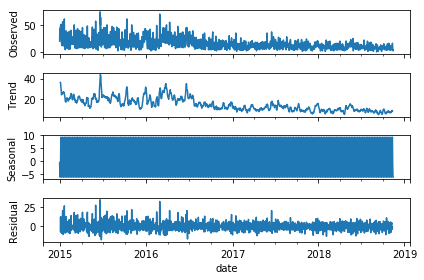

In [47]:
sm.seasonal_decompose(endog['checkins']).plot();

### Check stationarity of each endog variable

In [68]:
sm.stattools.adfuller(endog['checkins'].diff()[1:], maxlag=365) # diff order 1

(-7.345549209757116,
 1.0379278248391083e-10,
 78,
 1337,
 {'1%': -3.435250448324718,
  '10%': -2.567922207159556,
  '5%': -2.8637041654378903},
 6446.740574299611)

In [70]:
sm.stattools.adfuller(endog['sentiment'], maxlag=365)

(-36.42823109202843,
 0.0,
 0,
 1416,
 {'1%': -3.434976549531161,
  '10%': -2.5678578416363433,
  '5%': -2.86358329808087},
 -1004.7592671432512)

In [71]:
sm.stattools.adfuller(endog['stars'], maxlag=180)

(-35.6783982712553,
 0.0,
 0,
 1416,
 {'1%': -3.434976549531161,
  '10%': -2.5678578416363433,
  '5%': -2.86358329808087},
 3675.295743511985)

In [72]:
sm.stattools.adfuller(endog['influencer_rating'], maxlag=180)

(-11.3530396612084,
 9.887142871534791e-21,
 7,
 1409,
 {'1%': -3.434999576596685,
  '10%': -2.5678632530961614,
  '5%': -2.8635934599975106},
 1792.313077910948)

In [73]:
endog['checkin_diff'] = endog.checkins.diff()

In [84]:
model = sm.VAR(endog[['checkin_diff', 'stars', 'influencer_rating', 'sentiment']].dropna())

In [86]:
model.select_order(maxlags=30, trend='c').summary() # aic = 13, bic = 6, use 13 and see

,AIC,BIC,FPE,HQIC
0,-1.013,-0.9982,0.3630,-1.008
1,-1.006,-0.9302,0.3658,-0.9775
2,-1.013,-0.8773,0.3630,-0.9624
3,-1.113,-0.9164,0.3286,-1.039
4,-1.234,-0.9774,0.2911,-1.138
5,-1.476,-1.159,0.2286,-1.357
6,-1.565,-1.187*,0.2091,-1.424*
7,-1.556,-1.118,0.2109,-1.393
8,-1.568,-1.070,0.2084,-1.382
9,-1.557,-0.9983,0.2107,-1.348


In [87]:
results = model.fit(maxlags=13, ic='aic', trend='c')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Apr, 2019
Time:                     01:23:57
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.817887
Nobs:                     1403.00    HQIC:                  -1.31432
Log likelihood:          -6621.22    FPE:                   0.199789
AIC:                     -1.61064    Det(Omega_mle):        0.172249
--------------------------------------------------------------------
Results for equation checkin_diff
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         2.885221         2.036972            1.416           0.157
L1.checkin_diff              -0.585154         0.026608          -21.992           0.000
L1.stars             

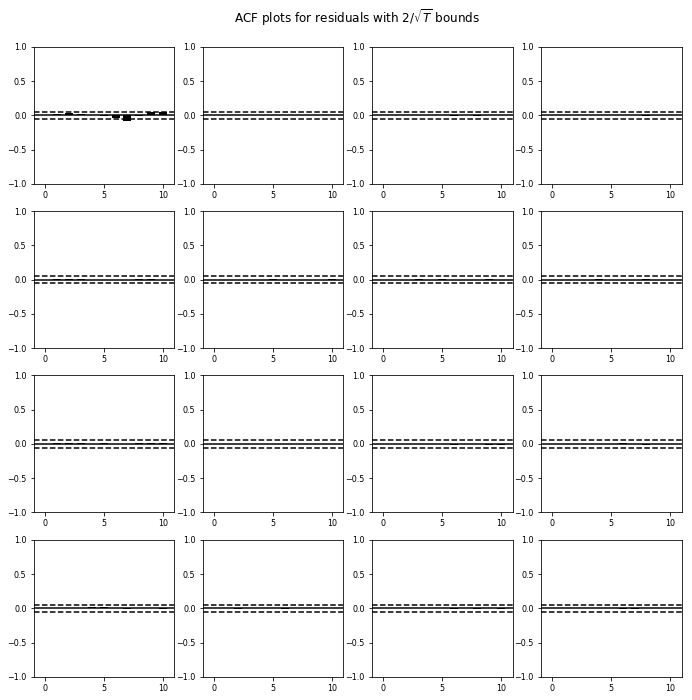

In [89]:
results.plot_acorr(resid=True); # no autocorrelation in residuals

In [93]:
print(results.is_stable())
results.test_whiteness(nlags=13).summary()

True


Test statistic,Critical value,p-value,df
45.74,nan,NAN,0


### Granger Causality and Impulse Response analysis

In [106]:
results.test_causality(0, causing=[1,2,3], kind='f').summary()

Test statistic,Critical value,p-value,df
1.299,1.402,0.101,"(39, 5400)"


In [110]:
results.test_inst_causality(causing=[1,2,3]).summary() # no orthogonal effects

Test statistic,Critical value,p-value,df
4.068,7.815,0.254,3


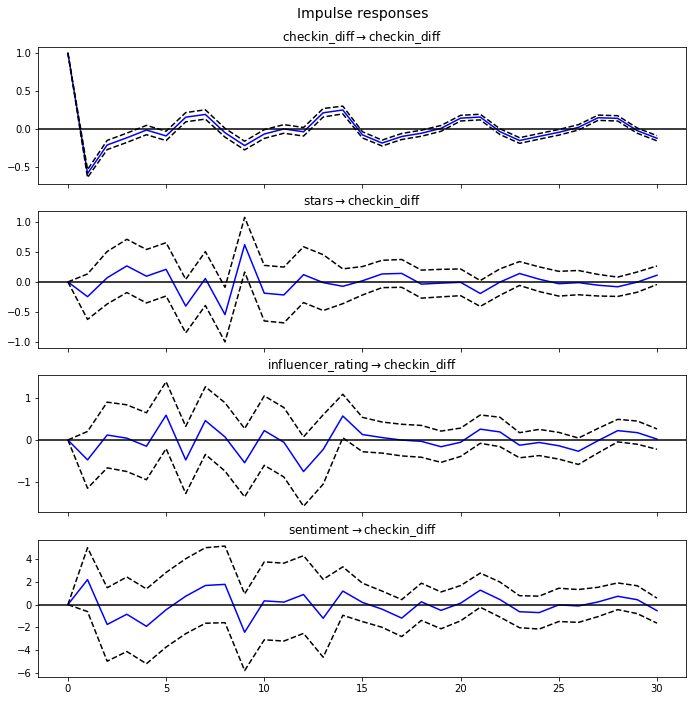

In [113]:
irf = results.irf(periods=30)
irf.plot(orth=False, response='checkin_diff', seed=12345);

In [118]:
endog['checkin_deseasoned'] = decomposed.trend

In [119]:
deseasoned_mod = sm.VAR(endog[['checkin_deseasoned', 'stars', 'influencer_rating', 'sentiment']].dropna())
deseasoned_mod.select_order(maxlags=30, trend='c').summary() # aic = 13, bic = 6, use 13 and see

,AIC,BIC,FPE,HQIC
0,-1.813,-1.797,0.1632,-1.807
1,-5.050,-4.974,0.006410,-5.022
2,-5.164,-5.028*,0.005719,-5.113
3,-5.187,-4.990,0.005587,-5.114
4,-5.180,-4.922,0.005629,-5.084
5,-5.171,-4.853,0.005680,-5.052
6,-5.165,-4.786,0.005714,-5.023
7,-5.162,-4.723,0.005730,-4.998
8,-5.362,-4.862,0.004690,-5.175
9,-5.404,-4.844,0.004497,-5.195*


In [120]:
deseasoned_res = deseasoned_mod.fit(maxlags=16, ic='aic', trend='c')

In [124]:
print(deseasoned_res.is_stable())
deseasoned_res.test_whiteness(nlags=22).summary()

True


Test statistic,Critical value,p-value,df
245.1,119.9,0.000,96


In [123]:
deseasoned_res.test_causality(0, [1,2,3]).summary()

Test statistic,Critical value,p-value,df
1.180,1.360,0.185,"(48, 5320)"


In [126]:
deseasoned_res.test_inst_causality([1,2,3]).summary()

Test statistic,Critical value,p-value,df
0.4691,7.815,0.926,3


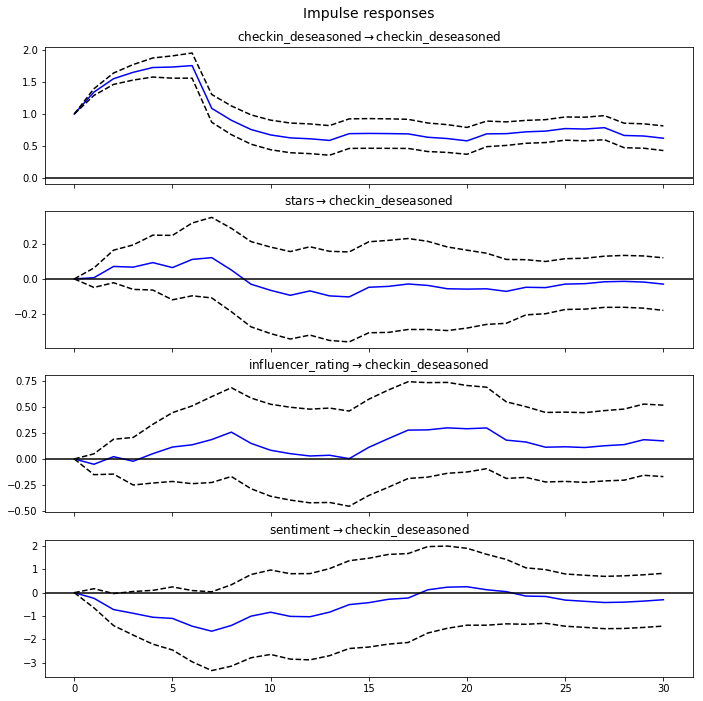

In [127]:
des_irf = deseasoned_res.irf(periods=30)
des_irf.plot(orth=False, response='checkin_deseasoned', seed=12345);

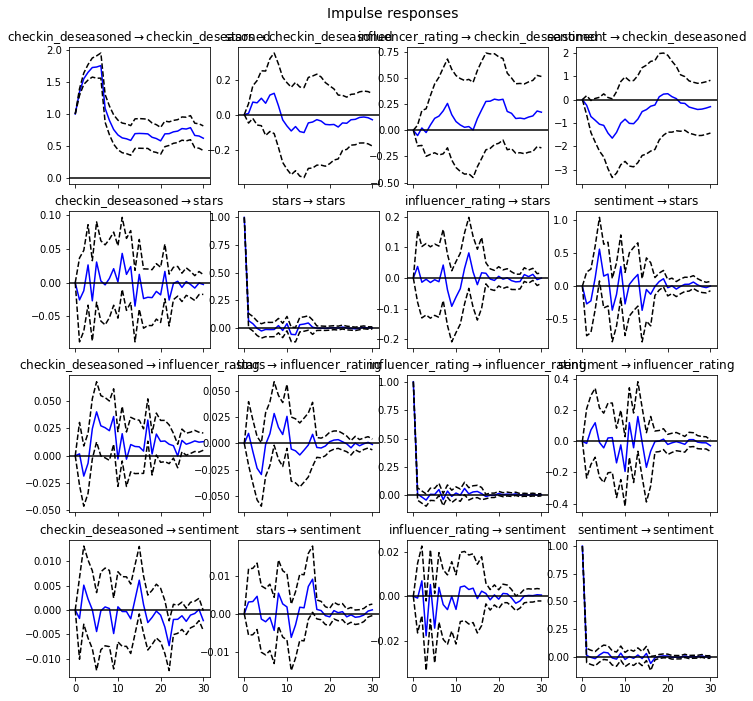

In [134]:
des_irf.plot(orth=False, seed=12345, plot_params={'ax':ax});

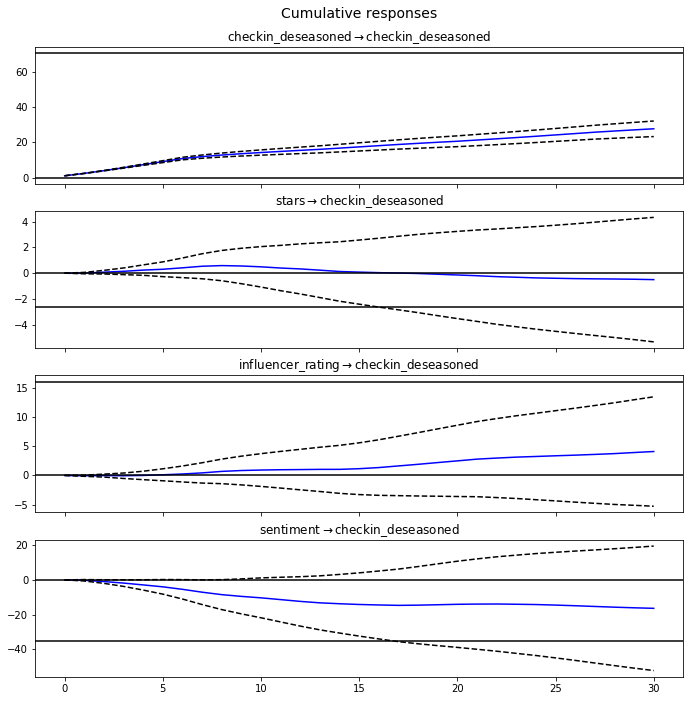

In [136]:
# cumulative effects over time per unit impulse
des_irf.plot_cum_effects(orth=False, response='checkin_deseasoned', seed=12345);

# Cheesecake Factory

In [135]:
cheese_reviews = load_matching_data('yelp_dataset/review.json',
                             key='business_id',
                             match_values=cheesecake.index.tolist(),
                             chunksize=20000)
cheese_users = load_matching_data('yelp_dataset/user.json',
                           key='user_id',
                           match_values=cheese_reviews.user_id.drop_duplicates().tolist(),
                           chunksize=20000)

In [137]:
df = cheese_reviews.merge(cheese_users, how='left',
                          left_on='user_id', right_index=True)
df['year'] = df.date.dt.year.astype(str)
df['is_elite'] = [x in y for x, y in zip(df.year.tolist(), df.elite.tolist())]
df['influence'] = df.is_elite.astype(int) * 100 + df.useful_x + df.funny_x + df.cool_x + df.fans + 1

In [140]:
influencers = df.groupby('user_id')['influence'].sum()\
                .sort_values(ascending=False)[:292]\
                .index.tolist()

In [141]:
df['influencer_rating'] = df.user_id.isin(influencers) \
                            * df.stars \
                            / df.average_stars # adjust for avg stars

In [142]:
# load checkins
checkins = load_matching_data('./yelp_dataset/checkin.json', 
                              key='business_id',
                              match_values=cheesecake.index.tolist(),
                              chunksize=20000,
                              set_index=False)
checkins.date = checkins.date.str.split(', ')

In [143]:
pd.to_datetime(checkins.date.sum()).dayofweek.value_counts() # sat and sun top

6    5401
5    4869
4    3280
0    3173
3    2828
2    2696
1    2628
dtype: int64

In [144]:
checkins.date.apply(len) # checkins dominated by several stores, more even distr.

1451      2781
6002       641
12084     1953
16752     1749
20575      626
48050     2252
48214     3656
56233     1613
62893     1199
73804     1002
97942      242
104918    1400
107577     718
107868    3791
116307     383
150634     869
Name: date, dtype: int64

In [145]:
checkin_times = pd.DataFrame(pd.to_datetime(checkins.date.sum()), columns=['datetime'])
checkin_times['dummy'] = 1
checkin_times['date'] = checkin_times.datetime.dt.date
checkin_times = checkin_times.groupby('date')['dummy'].sum()\
                            .asfreq('D').fillna(0.)

## Explore Time Series

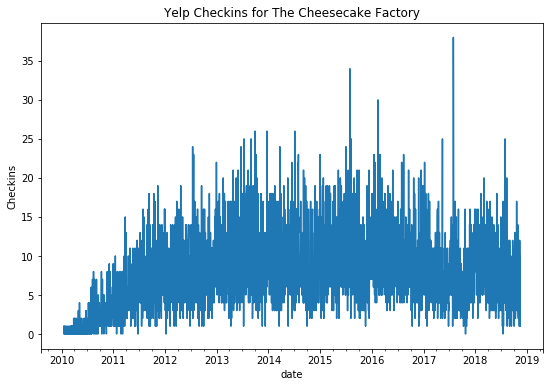

In [149]:
checkin_times.plot(figsize=(9,6));
plt.title('Yelp Checkins for The Cheesecake Factory')
plt.ylabel('Checkins');

In [151]:
df['sentiment'] = df.text.apply(lambda s: np.mean([nlp.polarity_scores(x)['compound']
                                                   for x in s.split('.')]))
df.date = df.date.dt.date

In [152]:
cheese_endog = df[['date', 'stars', 'sentiment', 'influencer_rating']]\
                    .groupby('date').agg({'stars':np.mean,
                                          'sentiment':np.mean,
                                          'influencer_rating':np.sum})
cheese_endog = cheese_endog.asfreq('D').fillna(0.0)
cheese_endog['checkins'] = checkin_times

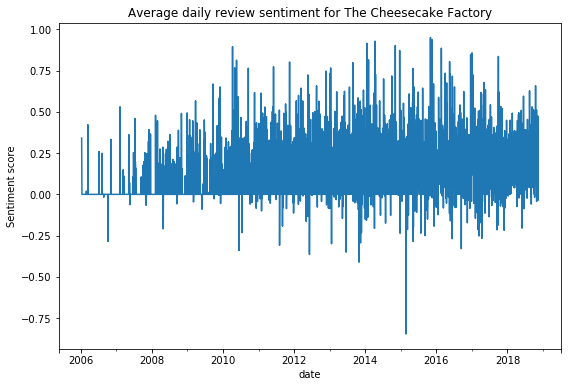

In [164]:
cheese_endog.sentiment.plot(figsize=(9,6));
plt.title('Average daily review sentiment for The Cheesecake Factory')
plt.ylabel('Sentiment score');

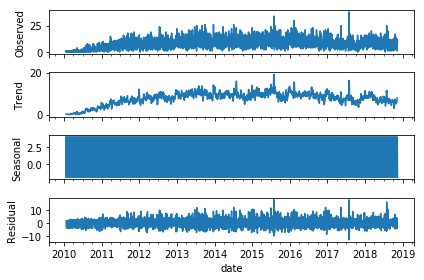

In [167]:
decomposed = sm.seasonal_decompose(cheese_endog['checkins'].dropna())
decomposed.plot();

## Check Stationarity

In [170]:
cheese_endog = cheese_endog.dropna()

In [183]:
sm.stattools.adfuller(cheese_endog['checkins'].diff()[1:], maxlag=365) # diff order 1

(-7.889189000403364,
 4.483981991711215e-12,
 118,
 3103,
 {'1%': -3.432459158186689,
  '10%': -2.567266070013851,
  '5%': -2.86247189450352},
 15419.541609790342)

In [184]:
sm.stattools.adfuller(decomposed.trend.dropna().diff()[1:], maxlag=365) # diff order 1

(-7.822284241479451,
 6.621064750165182e-12,
 139,
 3076,
 {'1%': -3.432477687087865,
  '10%': -2.5672704269177373,
  '5%': -2.8624800782492534},
 4319.9705613727765)

In [176]:
sm.stattools.adfuller(cheese_endog['stars'].diff()[1:], maxlag=180) # diff order 1

(-11.068365381544048,
 4.619949615471396e-20,
 70,
 3151,
 {'1%': -3.432427002601706,
  '10%': -2.5672585088743345,
  '5%': -2.8624576920765237},
 11528.77777699546)

In [181]:
sm.stattools.adfuller(cheese_endog['sentiment'].diff()[1:], maxlag=180) # diff order 1

(-16.579814370532592,
 1.83846065287264e-29,
 35,
 3186,
 {'1%': -3.432404167137761,
  '10%': -2.5672531392560596,
  '5%': -2.8624476060526383},
 -2002.5936819561066)

In [178]:
sm.stattools.adfuller(cheese_endog['influencer_rating'], maxlag=180)

(-57.199248313107056,
 0.0,
 0,
 3222,
 {'1%': -3.432381197225056,
  '10%': -2.567247737994645,
  '5%': -2.8624374605672154},
 2499.3837610681467)

In [186]:
cheese_model = sm.VAR(pd.DataFrame({'checkin_diff':cheese_endog['checkins'].diff(),
                                    'stars_diff':cheese_endog['stars'].diff(),
                                    'senti_diff':cheese_endog['sentiment'].diff(),
                                    'influencer_rating':cheese_endog['influencer_rating']})\
                          .dropna())

In [188]:
cheese_model.select_order(30, trend='c').summary()

,AIC,BIC,FPE,HQIC
0,-0.7826,-0.7750,0.4572,-0.7799
1,-1.442,-1.404,0.2365,-1.428
2,-1.755,-1.687,0.1729,-1.730
3,-1.930,-1.831,0.1452,-1.894
4,-2.060,-1.931,0.1274,-2.014
5,-2.260,-2.100,0.1043,-2.203
6,-2.450,-2.260*,0.08630,-2.382
7,-2.476,-2.255,0.08411,-2.397
8,-2.501,-2.250,0.08197,-2.411
9,-2.523,-2.241,0.08023,-2.422


In [189]:
cheese_res = cheese_model.fit(maxlags=27, ic='aic', trend='c')

In [192]:
print(cheese_res.is_stable())
cheese_res.test_whiteness(nlags=30).summary()

True


Test statistic,Critical value,p-value,df
184.5,65.17,0.000,48


## Granger causality and IRF

In [194]:
cheese_res.test_causality('checkin_diff', ['stars_diff', 'senti_diff', 'influencer_rating']).summary()

Test statistic,Critical value,p-value,df
1.494,1.273,0.003,"(81, 12344)"


In [195]:
cheese_res.test_inst_causality(['stars_diff', 'senti_diff', 'influencer_rating']).summary()
# orthogonal effects present

Test statistic,Critical value,p-value,df
10.74,7.815,0.013,3


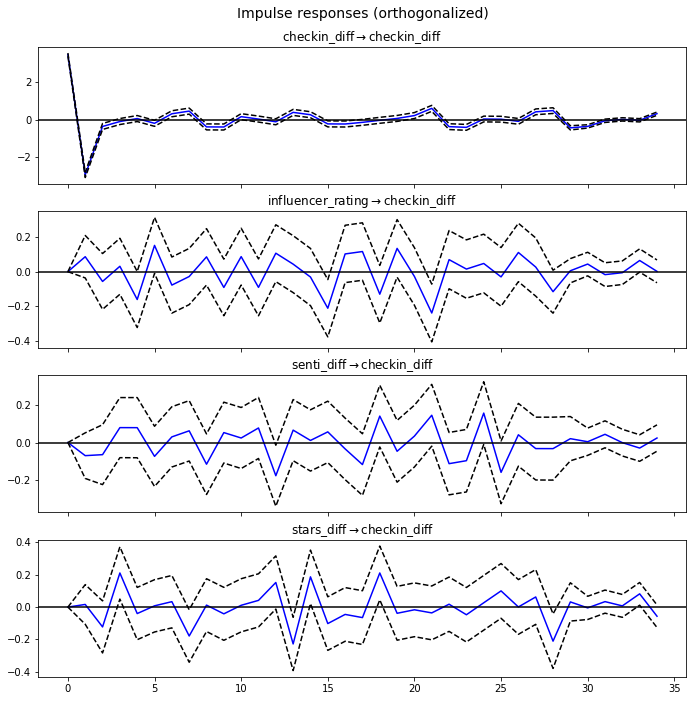

In [196]:
irf = cheese_res.irf(periods=34)
irf.plot(orth=True, response='checkin_diff', seed=12345);

In [199]:
# use deseasonalized checkins instead
des_cheese_model = sm.VAR(pd.DataFrame({'checkin_diff':decomposed.trend.diff(),
                                        'stars_diff':cheese_endog['stars'].diff(),
                                        'senti_diff':cheese_endog['sentiment'].diff(),
                                        'influencer_rating':cheese_endog['influencer_rating']})\
                          .dropna())

In [202]:
des_cheese_model.select_order(maxlags=27, trend='c').summary()

,AIC,BIC,FPE,HQIC
0,-4.882,-4.874,0.007582,-4.879
1,-5.448,-5.410,0.004304,-5.435
2,-5.707,-5.638,0.003324,-5.682
3,-5.832,-5.733,0.002933,-5.796
4,-5.909,-5.780,0.002714,-5.863
5,-5.951,-5.791,0.002603,-5.894
6,-5.988,-5.798,0.002509,-5.920
7,-6.250,-6.030,0.001930,-6.171
8,-6.275,-6.024,0.001882,-6.185
9,-6.294,-6.013,0.001847,-6.193


In [203]:
des_cheese_res = des_cheese_model.fit(maxlags=14, ic='aic', trend='c')
print(des_cheese_res.is_stable())
des_cheese_res.test_whiteness(nlags=30).summary()

True


Test statistic,Critical value,p-value,df
660.2,294.3,0.000,256


In [204]:
des_cheese_res.test_causality('checkin_diff',
                              ['stars_diff', 'senti_diff', 'influencer_rating']).summary()

Test statistic,Critical value,p-value,df
1.285,1.385,0.103,"(42, 12580)"


In [206]:
des_cheese_res.test_inst_causality(['stars_diff', 'senti_diff', 'influencer_rating']).summary()
# no orthogonal effects

Test statistic,Critical value,p-value,df
5.571,7.815,0.134,3


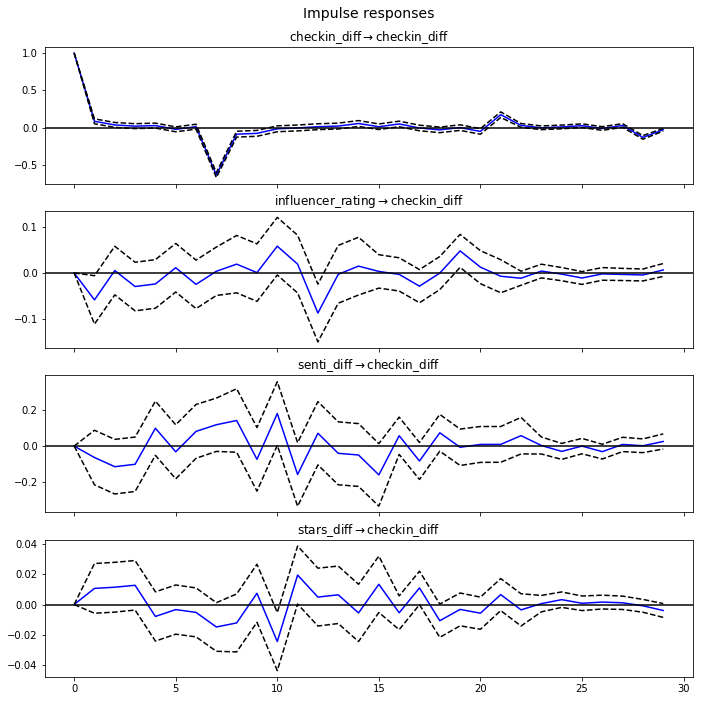

In [208]:
irf = des_cheese_res.irf(periods=29)
irf.plot(orth=False, response='checkin_diff', seed=12345);

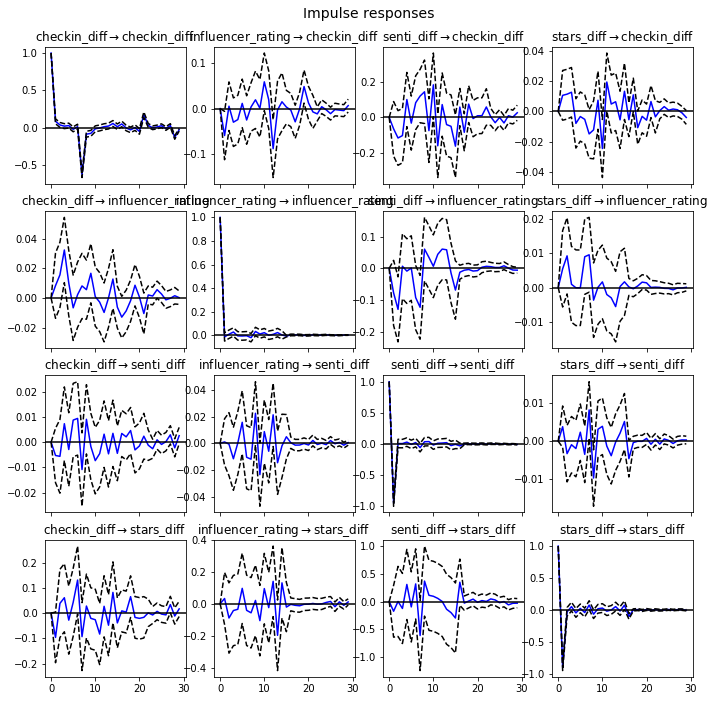

In [209]:
irf.plot(orth=False, seed=12345);

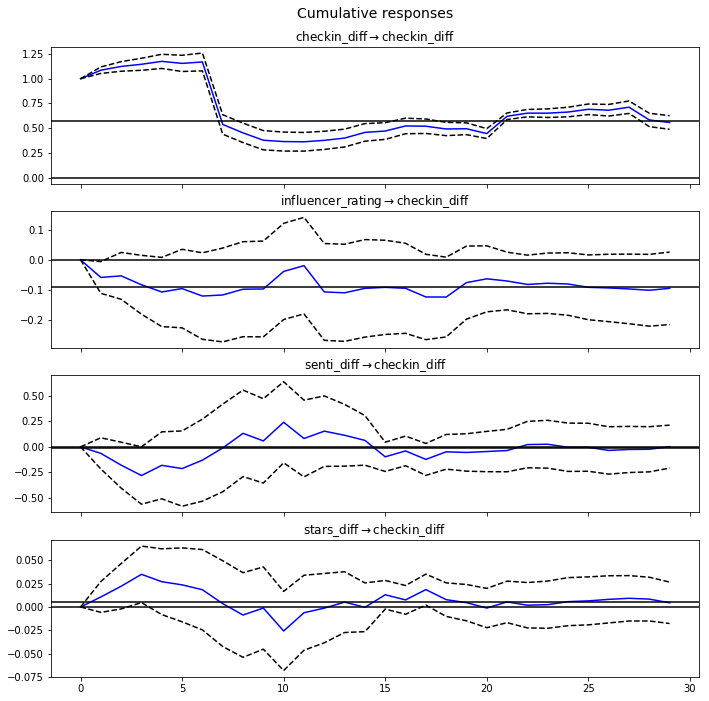

In [210]:
irf.plot_cum_effects(orth=False, response='checkin_diff', seed=12345);